# MNIST digit classifier - Jorge Martínez (AIAO M2BI)

### Load modules

In [22]:
import numpy as np
from pandas import read_csv
from sklearn import preprocessing

# Tensorflow and keras import
import tensorflow as tf
from   tensorflow import keras
from   keras import Input, Model

# Utils to manipulate data
#from keras.utils import np_utils
from keras.utils import to_categorical

# Keras models
from keras.models import Sequential

# Keras layers
from keras.layers import Dense, Dropout
from keras.layers import TimeDistributed
from keras.layers import add
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten


# Callback (for learning/optimize)
from keras import callbacks

from keras.callbacks  import TensorBoard

# Data analysis and protocol
from sklearn.model_selection     import cross_val_score
from sklearn.model_selection     import train_test_split
from sklearn.model_selection     import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

### Load data and viasualise it

In [2]:
# Load the data
train_images = np.load('../data/train_images.npy')
train_labels = np.load('../data/train_labels.npy')
test_images = np.load('../data/test_images.npy')
test_labels = np.load('../data/test_labels.npy')

In [3]:
# Check shape of the data
print("Shape of the train images:", train_images.shape)
print("Number of train labels:", train_labels.shape)
print("Shape of the test images:", test_images.shape)
print("Number of test labels:", test_labels.shape)

# Check how many classes there are
print("Classes in the train set:", np.unique(train_labels))
print("Classes in the test set:", np.unique(test_labels))

Shape of the train images: (60000, 28, 28, 1)
Number of train labels: (60000,)
Shape of the test images: (10000, 28, 28, 1)
Number of test labels: (10000,)
Classes in the train set: [0 1 2 3 4 5 6 7 8 9]
Classes in the test set: [0 1 2 3 4 5 6 7 8 9]


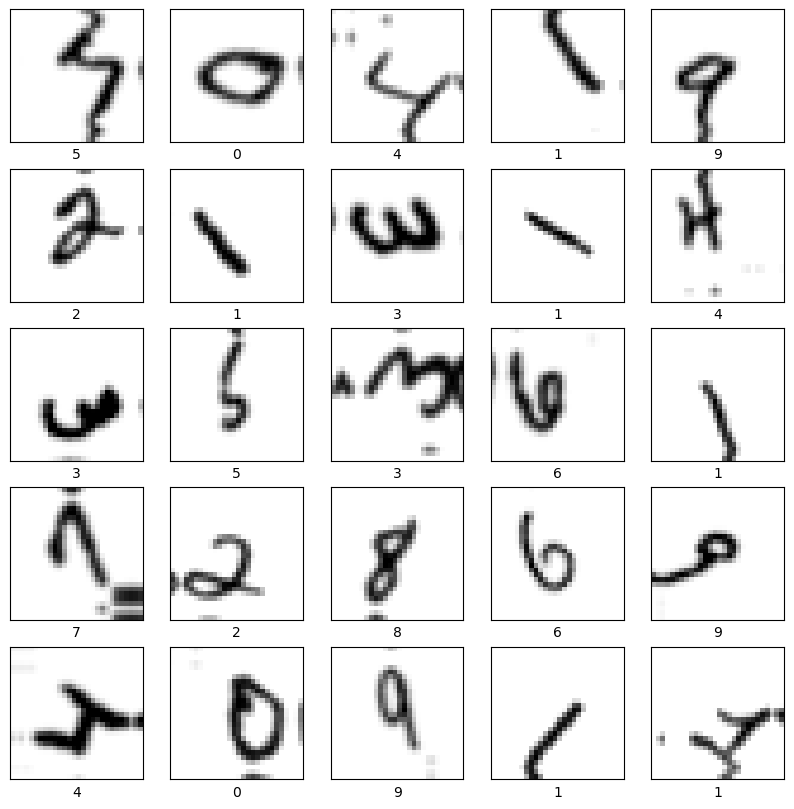

In [4]:
# Visualize the first 25 images of the train set
plt.figure(figsize=[10, 10])
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])

plt.show()

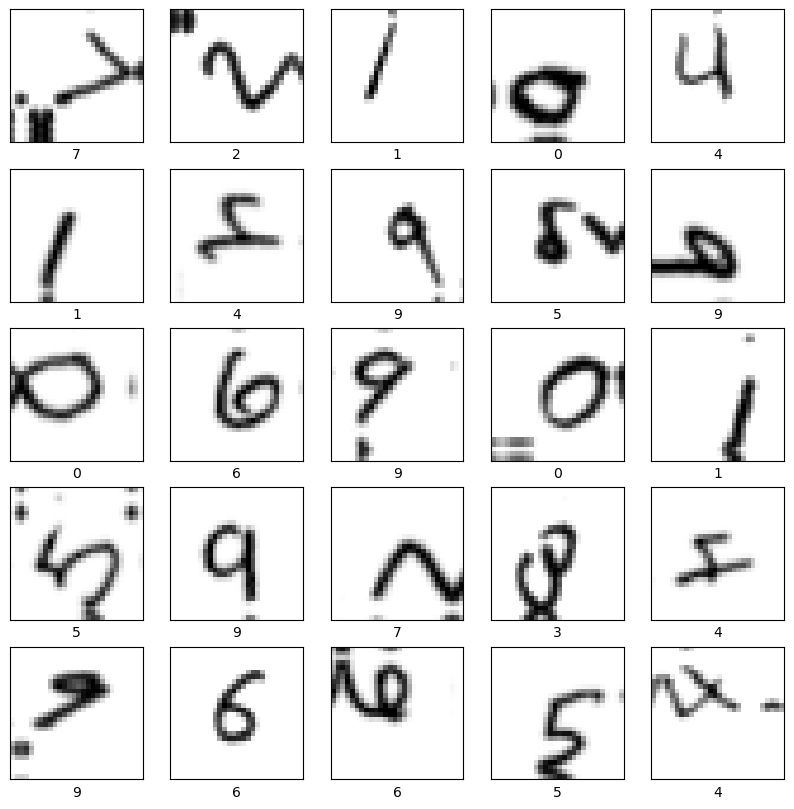

In [5]:
# Visualize the first 25 images of the test set
plt.figure(figsize=[10, 10])
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel(test_labels[i])

plt.show()

## DNN model

### Prepare the data

In [6]:
# Pre-format the images
train_images_dnn = train_images.astype("float32")
test_images_dnn = test_images.astype("float32")

num_pixels = train_images_dnn.shape[1] * train_images_dnn.shape[2]

# Flatten images
train_images_dnn = train_images_dnn.reshape(train_images_dnn.shape[0], num_pixels)
test_images_dnn = test_images_dnn.reshape(test_images_dnn.shape[0], num_pixels)

# Normalization
test_images_dnn /= 255

# One-hot encoding the target labels
num_classes = len(np.unique(train_labels))
train_labels_dnn = keras.utils.to_categorical(train_labels, num_classes)
test_labels_dnn = keras.utils.to_categorical(test_labels, num_classes)

### Build the model

In [7]:
def dense_model(num_pixels, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_dim=num_pixels),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Then use it like this:
model1 = dense_model(num_pixels, num_classes)
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [ ]:
# Flatten the images
dense_history = model1.fit(train_images_dnn, train_labels_dnn, validation_split=0.3, epochs=20, batch_size=100)

Epoch 1/20


2024-09-24 09:59:44.333859: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


420/420 [==============================] - 1s 2ms/step - loss: 1.7457 - accuracy: 0.3954 - val_loss: 1.3148 - val_accuracy: 0.5566
Epoch 2/20
420/420 [==============================] - 1s 2ms/step - loss: 1.1651 - accuracy: 0.6178 - val_loss: 0.9630 - val_accuracy: 0.6916
Epoch 3/20
420/420 [==============================] - 1s 2ms/step - loss: 0.9355 - accuracy: 0.6946 - val_loss: 0.8216 - val_accuracy: 0.7362
Epoch 4/20
420/420 [==============================] - 1s 2ms/step - loss: 0.8030 - accuracy: 0.7416 - val_loss: 0.7544 - val_accuracy: 0.7556
Epoch 5/20
420/420 [==============================] - 1s 2ms/step - loss: 0.7163 - accuracy: 0.7703 - val_loss: 0.7426 - val_accuracy: 0.7626
Epoch 6/20
420/420 [==============================] - 1s 2ms/step - loss: 0.6464 - accuracy: 0.7933 - val_loss: 0.6749 - val_accuracy: 0.7872
Epoch 7/20
420/420 [==============================] - 1s 2ms/step - loss: 0.5894 - accuracy: 0.8090 - val_loss: 0.6325 - val_accuracy: 0.8018
Epoch 8/20
420/42

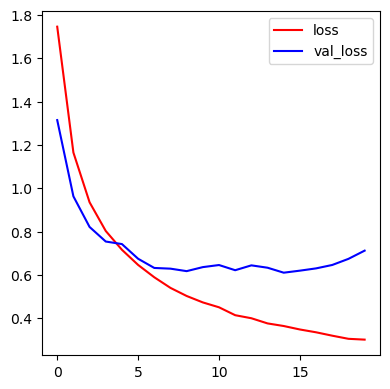

In [ ]:
plt.figure(figsize = (4,4))
plt.plot(dense_history.history["loss"], color = "red", label = "loss")
plt.plot(dense_history.history["val_loss"], color = "blue", label = "val_loss")
plt.legend()
plt.tight_layout()

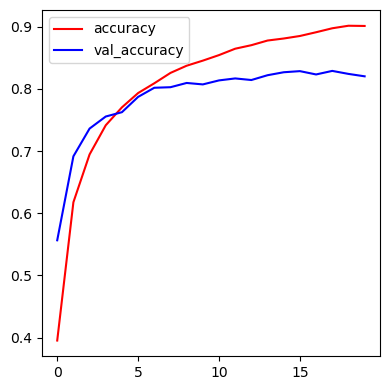

In [ ]:
plt.figure(figsize = (4,4))
plt.plot(dense_history.history["accuracy"], color = "red", label = "accuracy")
plt.plot(dense_history.history["val_accuracy"], color = "blue", label = "val_accuracy")
plt.legend()
plt.tight_layout()

### Evaluate the performance of the model

#### Evaluate performance on the train set

In [11]:
labs_pred_proba = model1.predict(train_images_dnn)

print(classification_report(np.argmax(train_labels_dnn, axis = 1), np.argmax(labs_pred_proba, axis = 1)))

1875/1875 [==============================] - 1s 421us/step
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      5923
           1       0.95      0.98      0.97      6742
           2       0.81      0.94      0.87      5958
           3       0.88      0.92      0.90      6131
           4       0.91      0.85      0.88      5842
           5       0.92      0.85      0.88      5421
           6       0.93      0.92      0.92      5918
           7       0.88      0.92      0.90      6265
           8       0.89      0.88      0.88      5851
           9       0.92      0.78      0.84      5949

    accuracy                           0.90     60000
   macro avg       0.90      0.90      0.90     60000
weighted avg       0.90      0.90      0.90     60000



[Text(0.5, 23.52222222222222, 'y_pred'),
 Text(50.722222222222214, 0.5, 'y_true')]

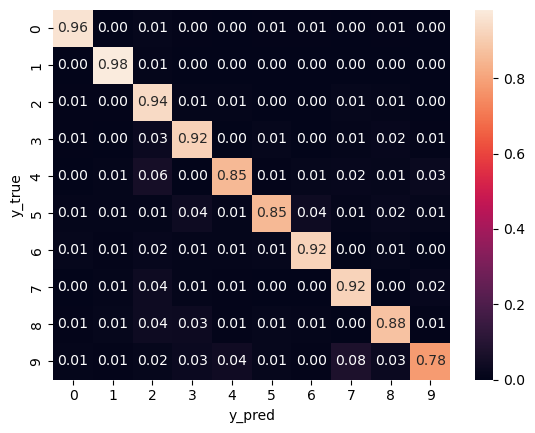

In [12]:
cm = sns.heatmap(confusion_matrix(np.argmax(train_labels_dnn, axis = 1),  np.argmax(labs_pred_proba, axis = 1), normalize = "true"),
                 annot = True, fmt='.2f')
cm.set(xlabel = "y_pred", ylabel = "y_true")

#### Evaluation on the test set

In [13]:
# On the test set
labs_pred_proba = model1.predict(test_images_dnn)

print(classification_report(np.argmax(test_labels_dnn, axis = 1), np.argmax(labs_pred_proba, axis = 1)))

313/313 [==============================] - 0s 439us/step
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       980
           1       0.91      0.96      0.93      1135
           2       0.71      0.86      0.78      1032
           3       0.79      0.84      0.82      1010
           4       0.81      0.73      0.76       982
           5       0.83      0.73      0.78       892
           6       0.86      0.83      0.84       958
           7       0.80      0.85      0.82      1028
           8       0.81      0.76      0.78       974
           9       0.83      0.68      0.74      1009

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



[Text(0.5, 23.52222222222222, 'y_pred'),
 Text(50.722222222222214, 0.5, 'y_true')]

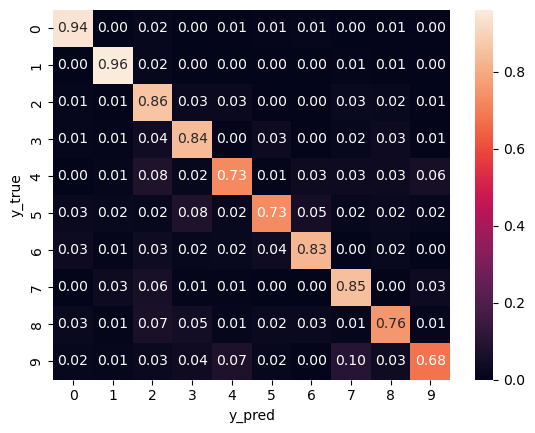

In [14]:
cm = sns.heatmap(confusion_matrix(np.argmax(test_labels_dnn, axis = 1),  np.argmax(labs_pred_proba, axis = 1), normalize = "true"),
                 annot = True, fmt='.2f')
cm.set(xlabel = "y_pred", ylabel = "y_true")

In [17]:
# Save the model
# model1.save('../res/model_dense.h5')

## CNN model

### Prepare the data

In [18]:
# Pre-format the images
train_images_cnn = train_images.astype("float32")
test_images_cnn = test_images.astype("float32")

# Normalize
test_images_cnn /= 255

# Reshape to have a single channel (black & white)
train_images_cnn = train_images_cnn.reshape(train_images_cnn.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

# One hot encoding
num_classes = len(np.unique(train_labels))
train_labels_cnn = keras.utils.to_categorical(train_labels, num_classes)
test_labels_cnn = keras.utils.to_categorical(test_labels, num_classes)

# Shuffle the data
np.random.seed(0)
shuffle_index = np.random.permutation(train_images_cnn.shape[0])
train_images_cnn = train_images_cnn[shuffle_index]
train_labels_cnn = train_labels_cnn[shuffle_index]

### Build the model

In [53]:
def cnn_model(num_pixels, num_classes):
    model = Sequential([
        Conv2D(input_shape = train_images_cnn.shape[1:],
                filters = 32,
                kernel_size = (3,3),
                activation = "relu"),
        MaxPooling2D(pool_size = (2,2)),
        Conv2D(filters = 64,
                kernel_size = (3,3),
                activation = "relu"),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Then use it like this:
model2 = cnn_model(num_pixels, num_classes)
model2.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1600)              0         
                                                                 
 dense_8 (Dense)             (None, 10)               

### Train the model

In [54]:
cnn_history = model2.fit(train_images_cnn, train_labels_cnn, 
                         validation_split=0.3, 
                         epochs=20, 
                         batch_size=100)

Epoch 1/20
420/420 [==============================] - 7s 16ms/step - loss: 1.5835 - accuracy: 0.4560 - val_loss: 1.1929 - val_accuracy: 0.6067
Epoch 2/20
420/420 [==============================] - 7s 16ms/step - loss: 1.0619 - accuracy: 0.6577 - val_loss: 0.9273 - val_accuracy: 0.7105
Epoch 3/20
420/420 [==============================] - 7s 16ms/step - loss: 0.8296 - accuracy: 0.7390 - val_loss: 0.7896 - val_accuracy: 0.7438
Epoch 4/20
420/420 [==============================] - 7s 16ms/step - loss: 0.6649 - accuracy: 0.7937 - val_loss: 0.6174 - val_accuracy: 0.8098
Epoch 5/20
420/420 [==============================] - 7s 16ms/step - loss: 0.5500 - accuracy: 0.8314 - val_loss: 0.5542 - val_accuracy: 0.8312
Epoch 6/20
420/420 [==============================] - 7s 16ms/step - loss: 0.4715 - accuracy: 0.8555 - val_loss: 0.4770 - val_accuracy: 0.8546
Epoch 7/20
420/420 [==============================] - 7s 18ms/step - loss: 0.4168 - accuracy: 0.8722 - val_loss: 0.4621 - val_accuracy: 0.8587

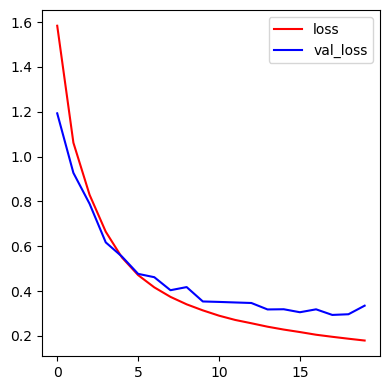

In [55]:
plt.figure(figsize = (4,4))
plt.plot(cnn_history.history["loss"], color = "red", label = "loss")
plt.plot(cnn_history.history["val_loss"], color = "blue", label = "val_loss")
plt.legend()
plt.tight_layout()

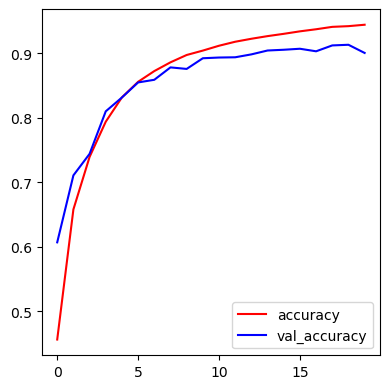

In [56]:
plt.figure(figsize = (4,4))
plt.plot(cnn_history.history["accuracy"], color = "red", label = "accuracy")
plt.plot(cnn_history.history["val_accuracy"], color = "blue", label = "val_accuracy")
plt.legend()
plt.tight_layout()

### Evaluate the performance of the model

#### Evaluate performance on the train set

In [57]:
labs_pred_proba = model2.predict(train_images_cnn)

print(classification_report(np.argmax(train_labels_cnn, axis = 1), np.argmax(labs_pred_proba, axis = 1)))

1875/1875 [==============================] - 5s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      5923
           1       0.99      0.97      0.98      6742
           2       0.91      0.90      0.91      5958
           3       0.95      0.95      0.95      6131
           4       0.95      0.91      0.93      5842
           5       0.96      0.89      0.92      5421
           6       0.91      0.96      0.93      5918
           7       0.95      0.90      0.92      6265
           8       0.79      0.97      0.87      5851
           9       0.94      0.89      0.92      5949

    accuracy                           0.93     60000
   macro avg       0.93      0.93      0.93     60000
weighted avg       0.93      0.93      0.93     60000



[Text(0.5, 23.52222222222222, 'y_pred'),
 Text(50.722222222222214, 0.5, 'y_true')]

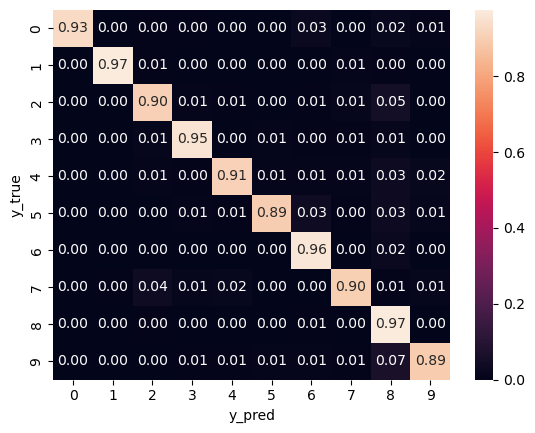

In [58]:
cm = sns.heatmap(confusion_matrix(np.argmax(train_labels_cnn, axis = 1),  np.argmax(labs_pred_proba, axis = 1), normalize = "true"),
                 annot = True, fmt='.2f')
cm.set(xlabel = "y_pred", ylabel = "y_true")

#### Evaluation on the test set

In [59]:
# On the test set
labs_pred_proba = model2.predict(test_images_cnn)

print(classification_report(np.argmax(test_labels_cnn, axis = 1), np.argmax(labs_pred_proba, axis = 1)))

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       980
           1       0.98      0.97      0.97      1135
           2       0.88      0.90      0.89      1032
           3       0.93      0.95      0.94      1010
           4       0.93      0.85      0.89       982
           5       0.92      0.88      0.90       892
           6       0.88      0.94      0.91       958
           7       0.93      0.86      0.89      1028
           8       0.78      0.96      0.86       974
           9       0.91      0.86      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



[Text(0.5, 23.52222222222222, 'y_pred'),
 Text(50.722222222222214, 0.5, 'y_true')]

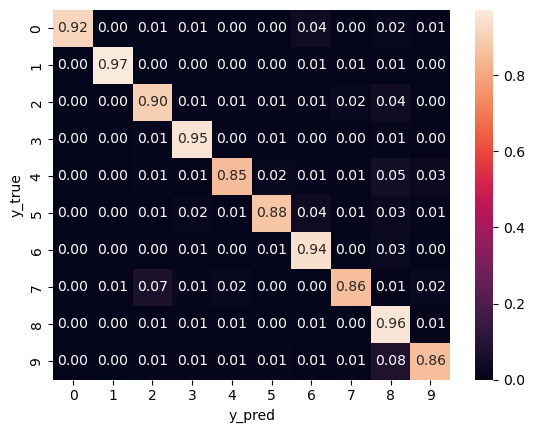

In [60]:
cm = sns.heatmap(confusion_matrix(np.argmax(test_labels_cnn, axis = 1),  np.argmax(labs_pred_proba, axis = 1), normalize = "true"),
                 annot = True, fmt='.2f')
cm.set(xlabel = "y_pred", ylabel = "y_true")

In [34]:
# Save the model
# model2.save('../res/model_conv.h5')

## CNN model - optim.

### Build the model

In [61]:
def cnn_model(num_pixels, num_classes):
    model = Sequential([
        Conv2D(input_shape = train_images_cnn.shape[1:],
                filters = 32,
                kernel_size = (3,3),
                activation = "relu"),
        MaxPooling2D(pool_size = (2,2)),
        Conv2D(filters = 64,
                kernel_size = (3,3),
                activation = "relu"),
        MaxPooling2D(pool_size = (2,2)),
        Dropout(0.25),
        Flatten(),
        Dense(units = 128,
                activation = "relu"),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Then use it like this:
model2 = cnn_model(num_pixels, num_classes)
model2.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 5, 5, 64)          0         
                                                                 
 flatten_5 (Flatten)         (None, 1600)             

### Train the model

In [62]:
cnn_history = model2.fit(train_images_cnn, train_labels_cnn, 
                         validation_split=0.3, 
                         epochs=20, 
                         batch_size=100)

Epoch 1/20
420/420 [==============================] - 8s 18ms/step - loss: 1.3215 - accuracy: 0.5497 - val_loss: 0.8224 - val_accuracy: 0.7264
Epoch 2/20
420/420 [==============================] - 7s 18ms/step - loss: 0.6392 - accuracy: 0.7987 - val_loss: 0.4459 - val_accuracy: 0.8660
Epoch 3/20
420/420 [==============================] - 8s 18ms/step - loss: 0.4334 - accuracy: 0.8645 - val_loss: 0.3363 - val_accuracy: 0.8964
Epoch 4/20
420/420 [==============================] - 8s 19ms/step - loss: 0.3349 - accuracy: 0.8962 - val_loss: 0.3115 - val_accuracy: 0.9049
Epoch 5/20
420/420 [==============================] - 8s 19ms/step - loss: 0.2755 - accuracy: 0.9159 - val_loss: 0.2773 - val_accuracy: 0.9176
Epoch 6/20
420/420 [==============================] - 8s 19ms/step - loss: 0.2344 - accuracy: 0.9265 - val_loss: 0.2537 - val_accuracy: 0.9234
Epoch 7/20
420/420 [==============================] - 8s 19ms/step - loss: 0.2049 - accuracy: 0.9361 - val_loss: 0.2026 - val_accuracy: 0.9401

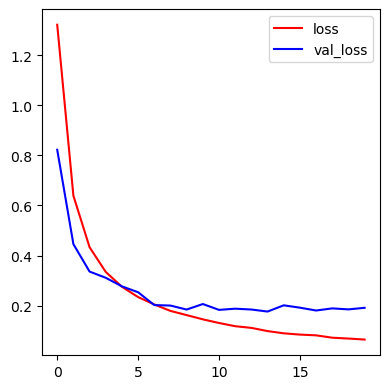

In [63]:
plt.figure(figsize = (4,4))
plt.plot(cnn_history.history["loss"], color = "red", label = "loss")
plt.plot(cnn_history.history["val_loss"], color = "blue", label = "val_loss")
plt.legend()
plt.tight_layout()

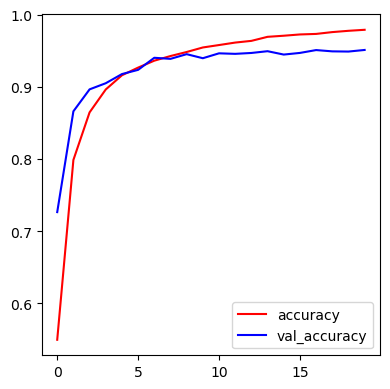

In [64]:
plt.figure(figsize = (4,4))
plt.plot(cnn_history.history["accuracy"], color = "red", label = "accuracy")
plt.plot(cnn_history.history["val_accuracy"], color = "blue", label = "val_accuracy")
plt.legend()
plt.tight_layout()

### Evaluate the performance of the model

#### Evaluate performance on the train set

In [65]:
labs_pred_proba = model2.predict(train_images_cnn)

print(classification_report(np.argmax(train_labels_cnn, axis = 1), np.argmax(labs_pred_proba, axis = 1)))

1875/1875 [==============================] - 5s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5923
           1       0.99      0.99      0.99      6742
           2       0.98      0.97      0.98      5958
           3       0.98      0.99      0.98      6131
           4       0.97      0.99      0.98      5842
           5       0.97      0.99      0.98      5421
           6       0.98      0.99      0.99      5918
           7       0.98      0.97      0.98      6265
           8       0.99      0.97      0.98      5851
           9       0.98      0.97      0.98      5949

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000



[Text(0.5, 23.52222222222222, 'y_pred'),
 Text(50.722222222222214, 0.5, 'y_true')]

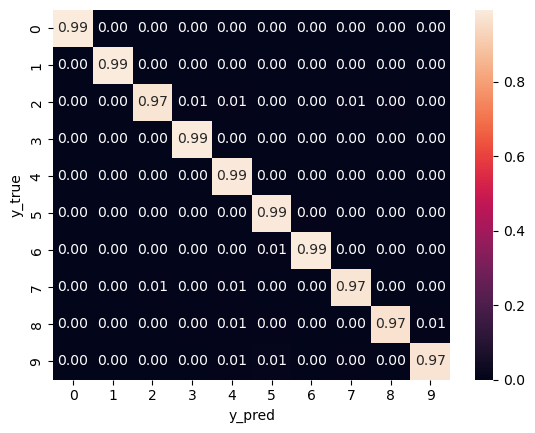

In [66]:
cm = sns.heatmap(confusion_matrix(np.argmax(train_labels_cnn, axis = 1),  np.argmax(labs_pred_proba, axis = 1), normalize = "true"),
                 annot = True, fmt='.2f')
cm.set(xlabel = "y_pred", ylabel = "y_true")

#### Evaluation on the test set

In [67]:
# On the test set
labs_pred_proba = model2.predict(test_images_cnn)

print(classification_report(np.argmax(test_labels_cnn, axis = 1), np.argmax(labs_pred_proba, axis = 1)))

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.94      0.95      0.95      1032
           3       0.94      0.98      0.96      1010
           4       0.93      0.96      0.94       982
           5       0.92      0.96      0.94       892
           6       0.96      0.96      0.96       958
           7       0.95      0.92      0.94      1028
           8       0.97      0.90      0.93       974
           9       0.95      0.92      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



[Text(0.5, 23.52222222222222, 'y_pred'),
 Text(50.722222222222214, 0.5, 'y_true')]

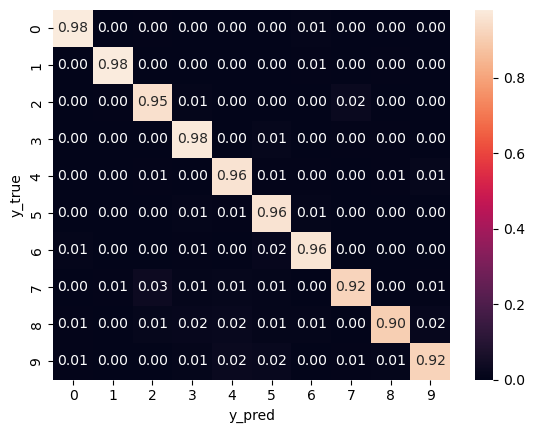

In [68]:
cm = sns.heatmap(confusion_matrix(np.argmax(test_labels_cnn, axis = 1),  np.argmax(labs_pred_proba, axis = 1), normalize = "true"),
                 annot = True, fmt='.2f')
cm.set(xlabel = "y_pred", ylabel = "y_true")

In [69]:
# Save the model
# model2.save('../res/model_conv_opt.h5')